In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as np
from jax import grad

In [3]:
f = lambda x : np.exp(x)
g = lambda x : np.square(x)
print(grad(f)(1.)) # = e^{1}
print(grad(grad(f))(1.))
print(grad(grad(grad(f)))(1.))

print(grad(g)(2.)) # 2x = 4
print(grad(grad(g))(2.)) # x = 2
print(grad(grad(grad(g)))(2.)) # x = 0

2.7182817
2.7182817
2.7182817
4.0
2.0
0.0


/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
from jax import random
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers
import matplotlib.pyplot as plt # visualization

In [5]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)
rng = random.PRNGKey(0)
in_shape = (-1, 1,)
out_shape, net_params = net_init(rng, in_shape)

In [6]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

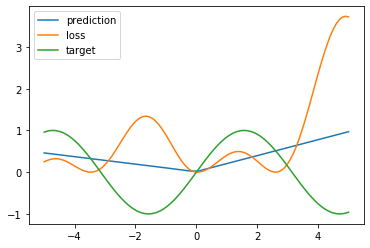

In [7]:
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [8]:
from tqdm.notebook import tqdm
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays

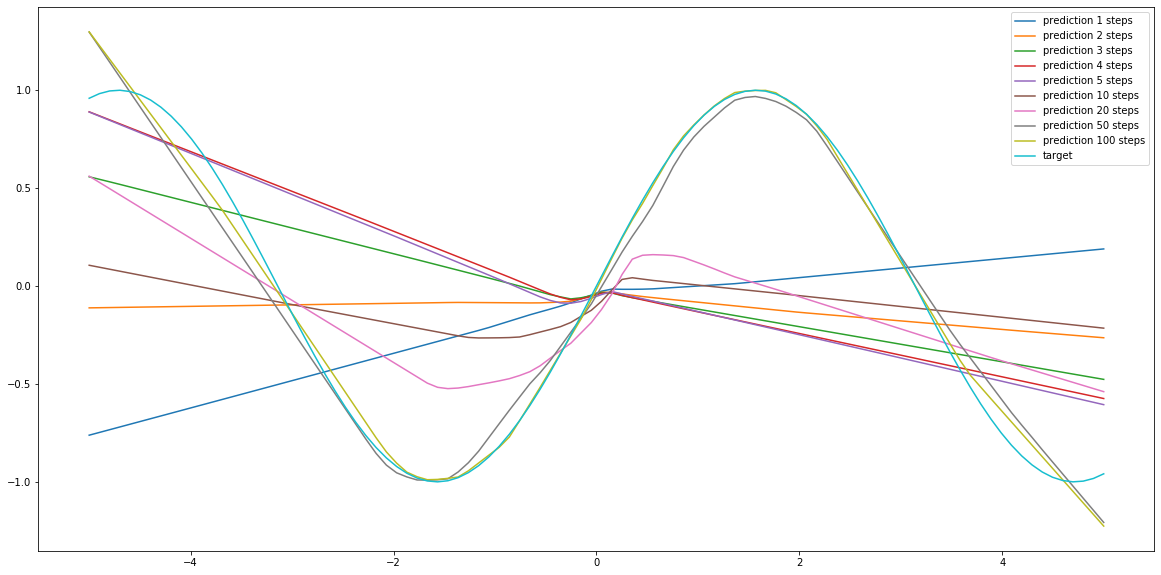

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
rng = random.PRNGKey(0)
for num_steps in tqdm([1, 2, 3, 4, 5, 10, 20, 50, 100]):
    
    net_init, net_apply = stax.serial(
        Dense(40), Relu,
        Dense(40), Relu,
        Dense(1)
    )
    
    in_shape = (-1, 1,)
    out_shape, net_params = net_init(rng, in_shape)
    
    def loss(params, inputs, targets):
        # Computes average loss for the batch
        predictions = net_apply(params, inputs)
        return np.mean((targets - predictions)**2)
    
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
    opt_state = opt_init(net_params)
    
    # Define a compiled update step
    @jit
    def step(i, opt_state, x1, y1):
        p = get_params(opt_state)
        g = grad(loss)(p, x1, y1)
        return opt_update(i, g, opt_state)
    
    for i in range(num_steps):
        opt_state = step(i, opt_state, xrange_inputs, targets)
    net_params = get_params(opt_state)

    # batch the inference across K=100
    targets = np.sin(xrange_inputs)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
    ax.plot(xrange_inputs, predictions, label='prediction %d steps' % num_steps)
    # plt.plot(xrange_inputs, losses, label='loss')

ax.plot(xrange_inputs, targets, label='target')
ax.legend()
plt.show()


In [10]:
g = lambda x, y : np.square(x) + y
x0 = 2.
y0 = 1.

print('grad(g)(x0) = {}'.format(grad(g)(x0, y0)))

grad(g)(x0) = 4.0


In [11]:
alpha = .1
def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [12]:
x1 = xrange_inputs
y1 = targets
x2 = np.array([0.])
y2 = np.array([0.])
maml_loss(net_params, x1, y1, x2, y2)

DeviceArray(0.00022761, dtype=float32)

In [17]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l
K=20

np_maml_loss = []

# Adam optimization
n_steps = 20000
pbar = tqdm(range(n_steps))
# for i in range(20000):
for i in pbar:
    # define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = A * onp.sin(x2 + phase)
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    # if i % 1000 == 0:
    #     print(i)
    
    pbar.set_postfix(loss=l)
    
net_params = get_params(opt_state)

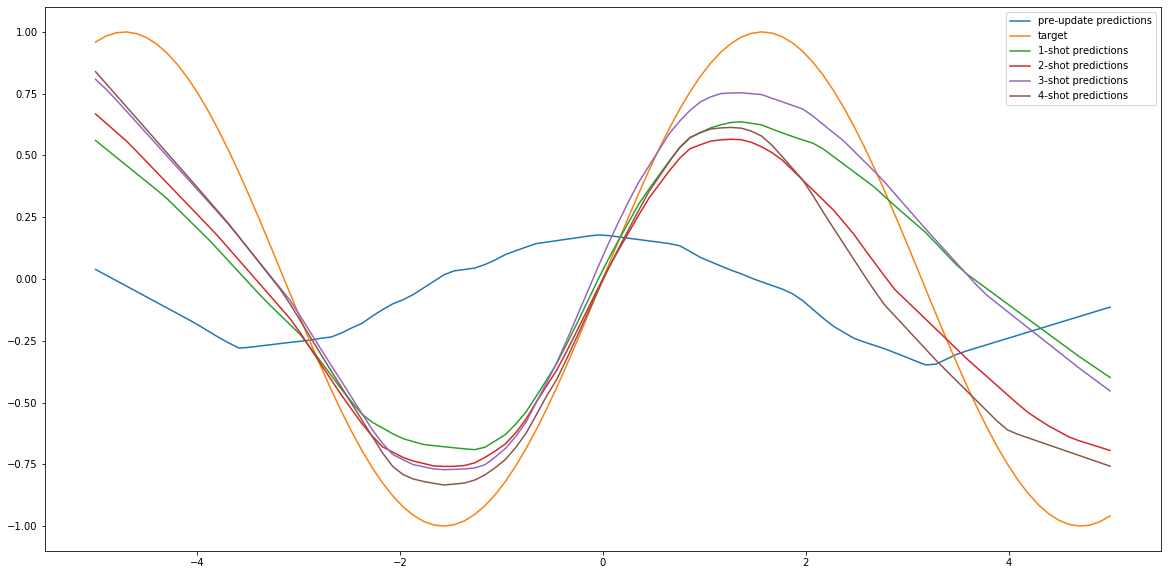

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
# batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
ax.plot(xrange_inputs, predictions, label='pre-update predictions')
ax.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    ax.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
ax.legend()
plt.show()

In [19]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

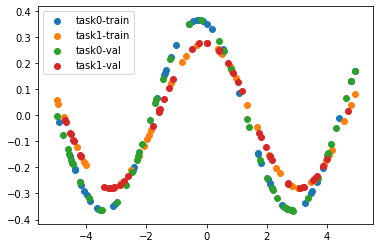

In [20]:
outer_batch_size = 2
x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50)
for i in range(outer_batch_size):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(outer_batch_size):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [37]:
opt_state

OptimizerState(packed_state=([DeviceArray([[-1.9526407e-01, -3.0589536e-01, -1.5505037e-01,
               2.3762014e-04,  3.6289040e-02, -1.4743484e-02,
              -1.7002150e-01,  4.9735773e-03, -2.0004516e-02,
               8.5972098e-04,  5.4756545e-02,  4.6593275e-02,
               2.1228044e-01, -2.4346824e-01, -1.6291262e-01,
              -1.1265463e-02,  2.0968926e-01, -1.5009925e-01,
              -4.1486491e-03,  3.1310198e-01,  1.2427825e-03,
               2.0745251e-01,  2.2368911e-01, -1.9606387e-02,
               1.8285987e-03,  1.3280796e-01, -1.5227833e-02,
              -2.7804327e-01, -1.8579106e-01, -1.9471337e-01,
              -2.5118789e-01,  6.8367616e-04,  3.1608433e-02,
              -1.4951229e-01, -1.3833717e-01,  1.2572418e-01,
               3.0466929e-01,  3.2043004e-01,  2.4262233e-01,
              -7.4579068e-02]], dtype=float32), DeviceArray([[-3.1370858e-03,  8.5181015e-04,  7.1599083e-05,
               0.0000000e+00, -3.0017982e-03, -1.74156

In [27]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K = 20
num_steps = 20000
pbar = tqdm(range(num_steps))
for i in pbar:
    x1_b, y1_b, x2_b, y2_b = sample_tasks(8, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    # if i % 1000 == 0:
     #   print(i)
    
net_params = get_params(opt_state)

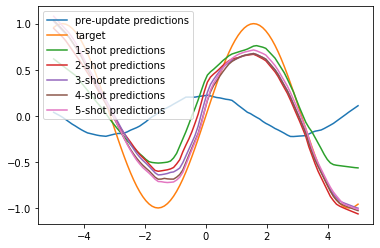

In [28]:
# batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(10,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,6):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

In [36]:
net_params[0][0]

DeviceArray([[-2.0806439e-01, -3.5569289e-01, -1.7783979e-01,
               2.3762014e-04, -4.8276071e-02,  7.6507531e-02,
              -1.6875014e-01,  4.9735773e-03, -1.4472322e-01,
               8.5972098e-04,  6.4463787e-02, -9.9196061e-02,
               1.9544718e-01, -2.7517709e-01, -1.7267956e-01,
               2.0339957e-01,  1.8511465e-01, -1.4823623e-01,
               1.3777566e-01,  2.9419559e-01, -2.3275360e-02,
               1.9884549e-01,  1.9436064e-01, -5.9306677e-03,
               1.7922483e-01,  1.1089700e-01,  1.6562466e-02,
              -2.9328182e-01, -2.4569081e-01, -2.5147575e-01,
              -2.5212568e-01,  6.8367616e-04,  9.2812635e-02,
              -1.8856500e-01, -1.5762362e-01,  1.0231070e-01,
               2.8254244e-01,  3.0470127e-01,  2.0759352e-01,
              -8.4101319e-02]], dtype=float32)

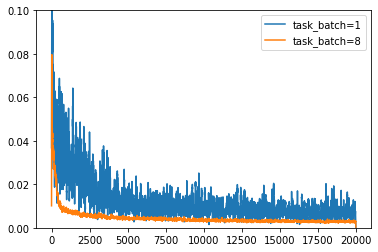

In [30]:
# Comparison of maml_loss for task batch size = 1 vs. task batch size = 8
plt.plot(onp.convolve(np_maml_loss, [.05]*20), label='task_batch=1')
plt.plot(onp.convolve(np_batched_maml_loss, [.05]*20), label='task_batch=8')
plt.ylim(0., 1e-1)
plt.legend()
